# Opening images in Keras
Todo:
 - Change from Pillow to rasterio to read image
 - 

Sources:
    - https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a
    - https://stackoverflow.com/questions/46493419/use-a-generator-for-keras-model-fit-generator
    - https://stackoverflow.com/questions/50195967/how-can-i-create-a-4d-numpy-array-from-images
    - https://www.google.com/search?client=firefox-b-ab&q=keras+make+image+generator
 

In [29]:
from PIL import Image

import keras
from PIL import Image

import imageio
import random
import scipy
import numpy as np

import rasterio
import numpy as np

import pandas
import geopandas


## Variables

In [2]:
image_dir_path = '../Sorted_tiles/'       # Path to images

## Read imagelabels

In [3]:
import pandas as pd
labelfile = pd.read_csv('../Qgis/labeled_tiles.csv')
labelfile.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0,stripe_merged_2_01_31.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,stripe_merged_2_01_32.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,stripe_merged_2_01_33.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,stripe_merged_2_01_34.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,stripe_merged_2_01_35.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1


In [4]:
labelfile.describe()

,ID,LIVSM1,LIVSM2,1,2,3,4,5,6,7,8,9,10,11,12,99
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.0,551.0,551.000000,551.000000,551.0,551.0,551.0,551.0,551.0,551.0,551.00000
mean,275.000000,91.228675,91.310345,0.023593,0.023593,0.0,0.0,0.058076,0.058076,0.0,0.0,0.0,0.0,0.0,0.0,0.91833
std,159.204271,26.088214,25.814159,0.151917,0.151917,0.0,0.0,0.234100,0.234100,0.0,0.0,0.0,0.0,0.0,0.0,0.27411
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
25%,137.500000,99.000000,99.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
50%,275.000000,99.000000,99.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
75%,412.500000,99.000000,99.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
max,550.000000,99.000000,99.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.00000


### Balance classes

In [7]:
# Stratified sample of the classes to get a balanced dataset with the same number of classes to train on.
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
# https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas

# Maximum number of elements in each class. If the classe have less than max every sample is included.
clasnumber_of_samples = 20

labelfile_balanced = labelfile.groupby(['LIVSM1'], group_keys=False).apply(lambda x: x.sample(min(len(x), clasnumber_of_samples))).reset_index(drop=True)
labelfile_balanced.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,200,stripe_merged_2_10_20.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0
1,305,stripe_merged_2_13_22.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0
2,443,stripe_merged_2_16_47.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0
3,403,stripe_merged_2_15_46.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0
4,306,stripe_merged_2_13_23.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Size of classes
labelfile_balanced_counted = labelfile_balanced.groupby('mult_bin_labels')['ID'].nunique()
labelfile_balanced_counted

mult_bin_labels
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]    20
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]    20
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    13
Name: ID, dtype: int64

## Homemade image data generator

In [9]:
def flip_vertical(image):
    return np.flipud(image)

def flip_horizontal(image):
    return np.fliplr(image)


def rotate_n_deg(image):
    # Rotates the image a random amount. Fills the space with a reflection of the image. Kva blir best her? Heller bruke rot90?
    rot = random.randrange(-180,180,30)
    rot_image = scipy.ndimage.interpolation.rotate(image, rot,axes=(1, 0), reshape=False, output=None, order=3, mode='reflect', cval=0.0, prefilter=True)

    return rot_image

#def rotate_180(image):
#    return np.rot90(image, k=2)

def random_image_flip_rotation(image):
    # This function rotates or flips the image randomly using one of five functions. 
    # This function can also do nothing to the image. 1/4 chanche.
    # Returns a image

    randint = np.random.randint(low=1, high=4)
    modified_image = 0
    
    if randint == 1:
        modified_image = flip_vertical(image)
    elif randint == 2:
        modified_image = flip_horizontal(image)

    elif randint == 3:
        modified_image = rotate_n_deg(image)

    else:
        modified_image = image
        
    return modified_image

A = np.array([[1, 2, 3], [4, 5, 6], [7,8,9]])
print(A)
print(flip_vertical(A))
print(flip_horizontal(A))
print(rotate_n_deg(A))
print(random_image_flip_rotation(A))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[7 8 9]
 [4 5 6]
 [1 2 3]]
[[3 2 1]
 [6 5 4]
 [9 8 7]]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[3 1 4]
 [6 5 4]
 [7 9 7]]


In [10]:
def get_input(path):
    
    img = imageio.imread(path)
    
    return(img)


def image_generator(image_path, label_file):
    # image_path: string where the images are placed.
    # label_file: csv file with labels and filenames.
    
    while True:
        batch_input = []
        batch_x = 0
        
        # Samples the file for a image, removes index so it can be used as loc[0]
        label_sample = label_file.sample().reset_index(drop=True)
        
        # Creates the file paths for the image
        image_sample_path = image_path + label_sample['Tile_name'].item()

        # Reads in each image as array, performs argumentation on each image
        input_raw = get_input(image_sample_path)
        input_permutated = random_image_flip_rotation(input_raw)
        
        # Add a new dimention to the array because Keras wants it this way?
        input_new_dim = np.expand_dims(input_permutated, axis=0)

        
        # Set a label by using the tile name. This line first finds the rowdata for 
        # a spesific tile and gives it out as a dataframe. Then the .iloc function 
        # finds the values of the colums 1 up to 99 and give them out as a list(list in a list). 
        label = label_sample.loc[0, ['1','2','3','4','5','6','7','8','9','10','11','12','99']].values
        
        # Place the labels inside a list in a list because Keras wants it this way??
        label = [[label]]

        yield(input_new_dim, label)

In [11]:
test_generated_images = image_generator(image_dir_path, labelfile_balanced)
generert = next(test_generated_images)
print(generert)
#print(next(test_generated_images))
print(np.shape(generert[0]))
print(generert[1])

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functiona

(array([[[[ 1.04401903e-02,  1.06333103e-02,  9.94040444e-03, ...,
           3.82071310e-16,  4.78152322e-16, -6.97667869e-18],
         [ 1.13995364e-02,  1.04327276e-02,  1.09141134e-02, ...,
           2.09938027e-15,  2.74761797e-15, -2.26783198e-16],
         [ 1.06517086e-02,  1.17491949e-02,  1.24829048e-02, ...,
          -8.21194803e-17, -1.07027093e-16, -4.01451960e-17],
         ...,
         [ 1.09766368e-02,  1.22601604e-02,  1.18222348e-02, ...,
          -3.33678120e-11, -1.32943732e-12,  1.00355781e-12],
         [ 9.23067052e-03,  1.08395992e-02,  1.08567467e-02, ...,
           6.34737792e-12,  6.79374227e-14,  1.37369134e-13],
         [ 9.88175720e-03,  9.99631267e-03,  1.10988738e-02, ...,
           1.15172615e-10,  1.24062609e-12,  1.70791126e-12]],

        [[ 9.13578458e-03,  8.69806483e-03,  1.05523877e-02, ...,
           3.99551476e-16,  5.15011702e-16, -2.92494973e-18],
         [ 1.18984776e-02,  9.30251554e-03,  1.03025474e-02, ...,
          -5.74704126

## Keras model

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 474)))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy",
                        "sparse_categorical_accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        273088    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                3341      
Total params: 293,069
Trainable params: 293,069
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit_generator(
        image_generator(image_dir_path, labelfile_balanced),
        steps_per_epoch=50,
        epochs=30)

Epoch 1/10
50/50 [==============================] - 15s 304ms/step - loss: 0.1147 - categorical_accuracy: 0.6400 - sparse_categorical_accuracy: 0.0446
Epoch 2/10
50/50 [==============================] - 15s 300ms/step - loss: 0.1063 - categorical_accuracy: 0.5600 - sparse_categorical_accuracy: 0.0508
Epoch 3/10
50/50 [==============================] - 15s 296ms/step - loss: 0.1289 - categorical_accuracy: 0.6400 - sparse_categorical_accuracy: 0.0831
Epoch 4/10
50/50 [==============================] - 15s 291ms/step - loss: 0.1204 - categorical_accuracy: 0.6200 - sparse_categorical_accuracy: 0.0954
Epoch 5/10
50/50 [==============================] - 17s 341ms/step - loss: 0.0805 - categorical_accuracy: 0.5200 - sparse_categorical_accuracy: 0.0662
Epoch 6/10
50/50 [==============================] - 15s 293ms/step - loss: 0.0940 - categorical_accuracy: 0.5400 - sparse_categorical_accuracy: 0.1677
Epoch 7/10
50/50 [==============================] - 13s 262ms/step - loss: 0.0801 - categorica

In [42]:
test_image_predict = labelfile_balanced.sample()
test_image_predict.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
16,84,stripe_merged_2_06_28.tif,5,6,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]",0,0,0,0,1,1,0,0,0,0,0,0,0


In [24]:
nn = model.predict_generator(
        image_generator(image_dir_path, test_image_predict),
        steps=1)
print(np.round(nn,2))

[[0.12 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.91]]


In [25]:
sum(nn[0])

1.1350760775371818

## Save model

In [26]:
model.save('../Models/simple_model0502.h5')

## Create points with predictions as attributes

In [30]:
predicted_classes_gdf = labelfile.copy()
predicted_classes_gdf.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0,stripe_merged_2_01_31.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,stripe_merged_2_01_32.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,stripe_merged_2_01_33.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,stripe_merged_2_01_34.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,stripe_merged_2_01_35.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1


In [31]:
predicted_classes_gdf = geopandas.GeoDataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'])
predicted_classes_gdf

,1,2,3,4,5,6,7,8,9,10,11,12,99


In [33]:
pp = pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'], data=test_image_predict)
pp

,1,2,3,4,5,6,7,8,9,10,11,12,99
50,0,0,0,0,0,0,0,0,0,0,0,0,1


In [34]:
%time
stored_labels = []

for num_tile, tile in labelfile.iterrows():
    # Convert pandas.series to pandas.dataframe so it works in image_generator. .T = transpose
    tile_dataframe = tile.to_frame().T 
    
    # Predict the labels of the tile
    pred_label = model.predict_generator(image_generator(image_dir_path, tile_dataframe), steps=1)
    # Store the label in a dataframe
    pred_label_dataframe = pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'], data=pred_label)
    
    # Save all labels in a dataframe
    predicted_classes_gdf = predicted_classes_gdf.append(pred_label_dataframe)
    



In [35]:
predicted_classes_gdf.reset_index(inplace=True, drop=True)
predicted_classes_gdf.head()

,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0.011207,0.010817,2.645384e-07,5.747953e-07,0.000090,0.000138,2.719218e-07,2.008260e-07,2.981693e-07,1.843437e-07,1.775778e-07,1.752457e-07,0.984747
1,0.057007,0.052107,2.016935e-07,4.004889e-07,0.000055,0.000075,2.260071e-07,1.539252e-07,2.025795e-07,1.540507e-07,1.336240e-07,1.565984e-07,0.937715
2,0.011240,0.009896,4.431670e-09,1.189932e-08,0.000005,0.000008,4.980988e-09,3.150404e-09,4.759814e-09,2.881911e-09,2.651277e-09,3.128643e-09,0.987820
3,0.009058,0.007752,2.983590e-09,7.820039e-09,0.000005,0.000008,3.376411e-09,2.100496e-09,3.128070e-09,1.882327e-09,1.700874e-09,2.041766e-09,0.989106
4,0.008903,0.008375,7.908540e-08,1.852956e-07,0.000040,0.000064,8.285424e-08,5.901290e-08,8.872887e-08,5.324563e-08,5.100501e-08,5.179292e-08,0.988183


In [36]:
%time
image_dir_path = '../Sorted_tiles/' 

gdf = geopandas.GeoDataFrame()

for num_tile, tile in labelfile.iterrows():
    
    # Find image path
    tile_path = image_dir_path + tile['Tile_name']
    
    # Open image and find image bounds
    tile_opened = rasterio.open(tile_path)
    tile_bounds = tile_opened.bounds
    
    # Create and store geometry
    tile_bounds_geometry = geopandas.base.box(tile_bounds[0], tile_bounds[1], tile_bounds[2], tile_bounds[3])
    gdf = gdf.append([tile_bounds_geometry])

# Rename geometry colum and create a new index
gdf.columns = ['geometry']
gdf.reset_index(inplace=True, drop=True)

In [37]:
gdf.head()

,geometry
0,"POLYGON ((587171.55 6757675.55, 587171.55 6757..."
1,"POLYGON ((587186.55 6757675.55, 587186.55 6757..."
2,"POLYGON ((587201.55 6757675.55, 587201.55 6757..."
3,"POLYGON ((587216.55 6757675.55, 587216.55 6757..."
4,"POLYGON ((587231.55 6757675.55, 587231.55 6757..."


In [38]:
#predicted_classes_gdf
#result = pd.concat([predicted_classes_gdf, gdf], sort=False)
#result = geopandas.GeoDataFrame( pd.concat( [predicted_classes_gdf, gdf], ignore_index=True,sort=False) )
result = gdf.merge(predicted_classes_gdf, right_index=True, left_index=True)
result

,geometry,1,2,3,4,5,6,7,8,9,10,11,12,99
0,"POLYGON ((587171.55 6757675.55, 587171.55 6757...",0.011207,0.010817,2.645384e-07,5.747953e-07,9.045195e-05,1.382139e-04,2.719218e-07,2.008260e-07,2.981693e-07,1.843437e-07,1.775778e-07,1.752457e-07,0.984747
1,"POLYGON ((587186.55 6757675.55, 587186.55 6757...",0.057007,0.052107,2.016935e-07,4.004889e-07,5.468222e-05,7.547458e-05,2.260071e-07,1.539252e-07,2.025795e-07,1.540507e-07,1.336240e-07,1.565984e-07,0.937715
2,"POLYGON ((587201.55 6757675.55, 587201.55 6757...",0.011240,0.009896,4.431670e-09,1.189932e-08,5.024213e-06,8.446014e-06,4.980988e-09,3.150404e-09,4.759814e-09,2.881911e-09,2.651277e-09,3.128643e-09,0.987820
3,"POLYGON ((587216.55 6757675.55, 587216.55 6757...",0.009058,0.007752,2.983590e-09,7.820039e-09,4.689228e-06,7.997535e-06,3.376411e-09,2.100496e-09,3.128070e-09,1.882327e-09,1.700874e-09,2.041766e-09,0.989106
4,"POLYGON ((587231.55 6757675.55, 587231.55 6757...",0.008903,0.008375,7.908540e-08,1.852956e-07,4.027642e-05,6.379245e-05,8.285424e-08,5.901290e-08,8.872887e-08,5.324563e-08,5.100501e-08,5.179292e-08,0.988183
5,"POLYGON ((587246.55 6757675.55, 587246.55 6757...",0.025706,0.027497,9.822493e-05,1.418517e-04,9.427727e-03,1.107431e-02,8.120193e-05,7.844073e-05,1.008175e-04,7.407468e-05,7.463113e-05,6.642305e-05,0.935425
6,"POLYGON ((587141.55 6757660.55, 587141.55 6757...",0.015183,0.015370,2.587190e-06,4.804780e-06,4.886911e-04,6.893878e-04,2.507083e-06,2.034089e-06,2.896265e-06,1.886508e-06,1.859988e-06,1.705719e-06,0.975761
7,"POLYGON ((587156.55 6757660.55, 587156.55 6757...",0.018242,0.016042,7.828697e-08,1.444360e-07,6.165413e-05,9.482714e-05,8.295876e-08,5.705812e-08,7.443784e-08,5.372038e-08,4.465160e-08,5.348850e-08,0.971932
8,"POLYGON ((587171.55 6757660.55, 587171.55 6757...",0.015399,0.012447,2.130394e-07,2.591461e-07,5.965442e-04,7.452423e-04,1.895371e-07,1.484292e-07,1.585137e-07,1.366151e-07,9.968826e-08,1.316851e-07,0.932731
9,"POLYGON ((587186.55 6757660.55, 587186.55 6757...",0.000451,0.000337,2.242448e-14,1.549890e-13,9.247740e-10,2.231680e-09,2.891556e-14,1.312965e-14,2.818417e-14,9.694816e-15,1.004248e-14,1.296575e-14,0.999671


In [41]:
gdf_test = geopandas.GeoDataFrame(result, geometry='geometry')
gdf_test.crs = {'init' :'epsg:32632'}
type(gdf_test)

geopandas.geodataframe.GeoDataFrame

In [40]:
# Export shapefile
gdf_test.to_file('../Models/predictions_model0402.shp', driver='ESRI Shapefile')

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## Notes

In [ ]:
create dataframe

for element in list:
    predict tile labels
    store in dataframe
        
    get tile bounds
    convert tilebounds to polygon
    store in dataframe
    
save as shp with correct epsg

In [431]:
import rasterio
sus = '../Sorted_tiles/' + test_image_predict['Tile_name'].item()
raster = rasterio.open(sus)
suli = raster.bounds
uli = raster.xy(25,25)

print(suli)
print(uli)

BoundingBox(left=587336.55, bottom=6757630.55, right=587351.55, top=6757645.55)
(587344.2000000001, 6757637.899999999)


In [460]:
b = geopandas.base.box(suli[0], suli[1], suli[2], suli[3])
#b = geopandas.base.box(suli[0], suli[2], suli[1], suli[3])

d = {'col1': [1], 'col2': [3]}
ddf = pd.DataFrame(data=d)

gdf = geopandas.GeoDataFrame(ddf, geometry=[b])
gdf.head()

,col1,col2,geometry
0,1,3,"POLYGON ((587351.55 6757630.55, 587351.55 6757..."


<Figure size 432x288 with 0 Axes>

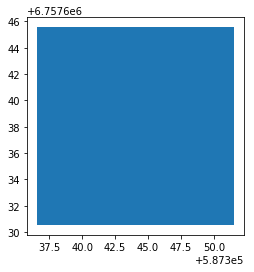

In [453]:
import matplotlib.pyplot as plt
# Plot mis-polygons
plt.figure()
gdf.plot()
plt.show()